# P4 Advanced Lane Lines
## Thomas J. Chmielenski
## September 2017
---

In this project, the goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available  in this project repository.

More specifically, the goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [1]:
### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

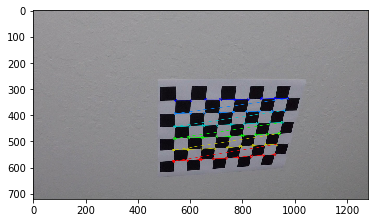

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

def  compute_camera_calibration_coefficents(calibration_images ='./camera_cal/calibration*.jpg', nx = 9, ny =6):
    images = glob.glob(calibration_images)

    # Arrays to store object points and image points from all the images
    objpoints =[] #3D points in real world space
    imgpoints =[] #2D points in image plane

    # Prepare object points, like (0,0, 0), (1,0,0), (2,0,0), ...,  (7,5,0)
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 

    for fname in images:
        # Read om each image
        img = mpimg.imread(fname)
    
        # Convert image to grayscale
        # mpimg.imread() this will read in an RGB image
        # cv2.imread () or glob API this will read in a BGR image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        # If corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
               
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            if (len(objpoints) == 1):                               
                # first out the first image
                plt.imshow(img)
                plt.savefig('./output_images/chessboard.png')
                plt.show()

    # To calibrate a camera
    # gray.shape[::-1] is equivalent to img.shape[0:2] <-- first two values of a color image shape
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (ret, mtx, dist, rvecs, tvecs)

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
(ret, mtx, dist, rvecs, tvecs) = compute_camera_calibration_coefficents (calibration_images =  './camera_cal/calibration*.jpg', nx = nx, ny = ny)



dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open( "./calibration_pickle.p", "wb"))

# Undistort
#dst = cv2.undistort(img, mtx, dist, None, mtx)


In [3]:
### Apply a distortion correction to raw images.

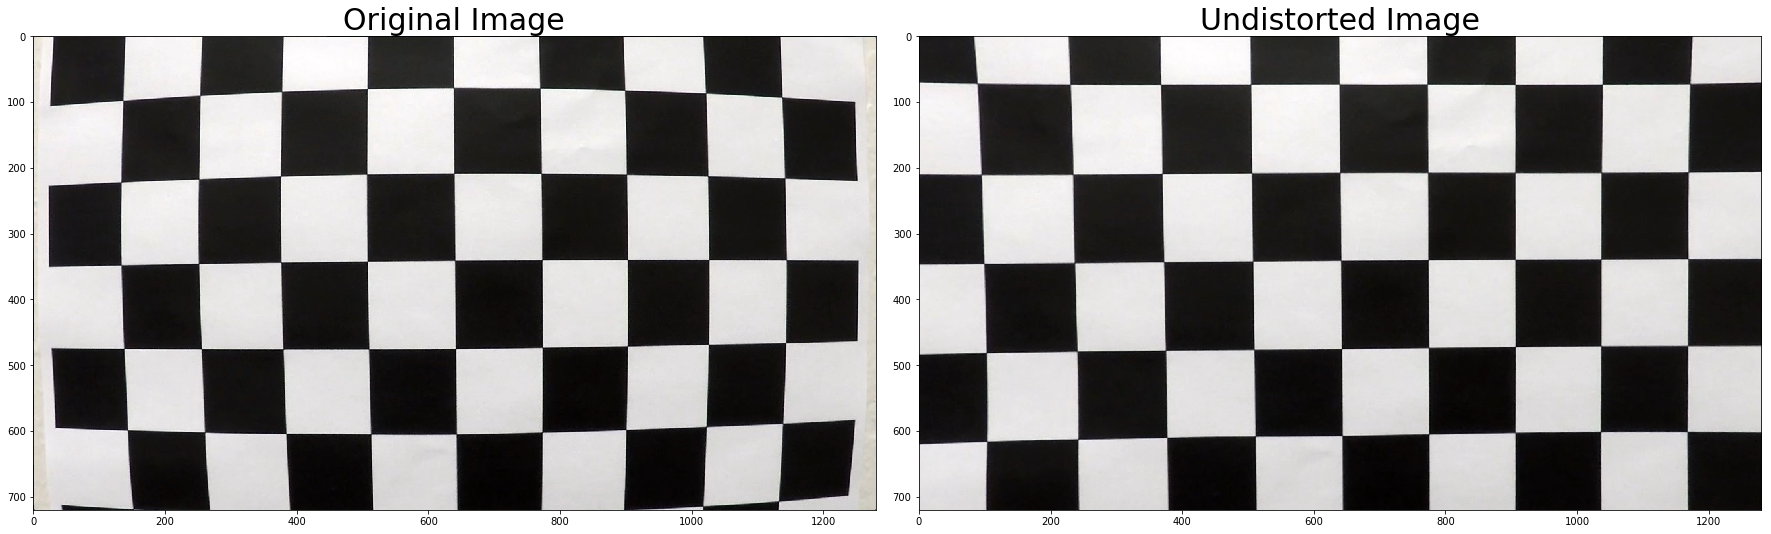

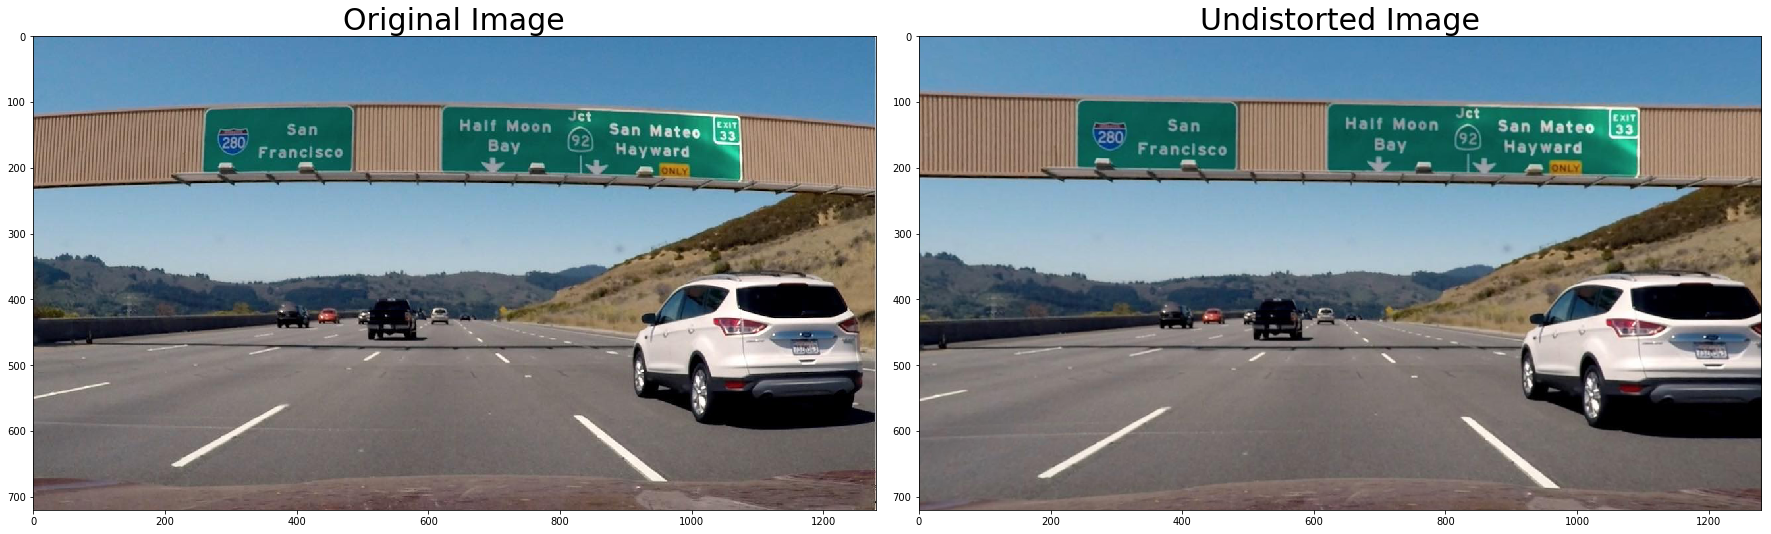

In [41]:
# Plot the result
def plotImage(image, image_cmap=None,  save_filename=None):
    plt.imshow(image,cmap=image_cmap)
    if save_filename:
        plt.savefig(save_filename)
    plt.show()
    
def plot2images(image1, image2, title1, title2, image1cmap=None, image2cmap='gray', save_filename=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap=image1cmap)
    ax1.set_title(title1, fontsize= 30)
    ax2.imshow(image2, cmap=image2cmap)
    ax2.set_title(title2, fontsize= 30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if save_filename:
        plt.savefig(save_filename)
    plt.show()
    
image = mpimg.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(image, mtx, dist, None, mtx)
plot2images(image1=image, image2=dst, title1='Original Image', title2='Undistorted Image', save_filename='output_images/orig_vs_undistorted_image.png')

image = mpimg.imread('./examples/signs_vehicles_xygrad.png')
dst = cv2.undistort(image, mtx, dist, None, mtx)
plot2images(image1=image, image2=dst, title1='Original Image', title2='Undistorted Image', save_filename='output_images/orig_vs_undistorted_image2.png')



### Use color transforms, gradients, etc., to create a thresholded binary image.

Notes:

* RGB matplotlib.image.imread()
* BGR cv2.imread()
* HSV color space (hue, saturation, and value), and 
* HLS space (hue, lightness, and saturation)


In [5]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    #plot2images(image1=image, image2=grad_binary, title1='Original Image', title2='thresholded y-derivative', save_filename='output_images/thresholdedy-derivative.png')

    # Return the result
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    #plot2images(image1=image, image2=mag_binary, title1='Original Image', title2='Thresholded Magnitude', save_filename='output_images/thresholded_magnitude.png')

    # Return the binary image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    #plot2images(image1=image, image2=dir_binary, title1='Original Image', title2='Thresholded Direction', save_filename='output_images/thresholded_direction.png')

    return dir_binary


#Self-Driving Car Project Q&A | Advanced Lane Finding
def color_threshold(image, s_thresh=(0, 255), v_thresh=(0, 255)):
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    V = hsv[:,:,2]
    
    v_binary = np.zeros_like(V)
    v_binary[(S > v_thresh[0]) & (V <= v_thresh[1])] = 1
    
    combined = np.zeros_like(S)
    combined[((s_binary == 1) & (v_binary == 1))] = 1
    
    return combined

def window_mask (width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level+height, max(0,int(center-width)))]
    return output



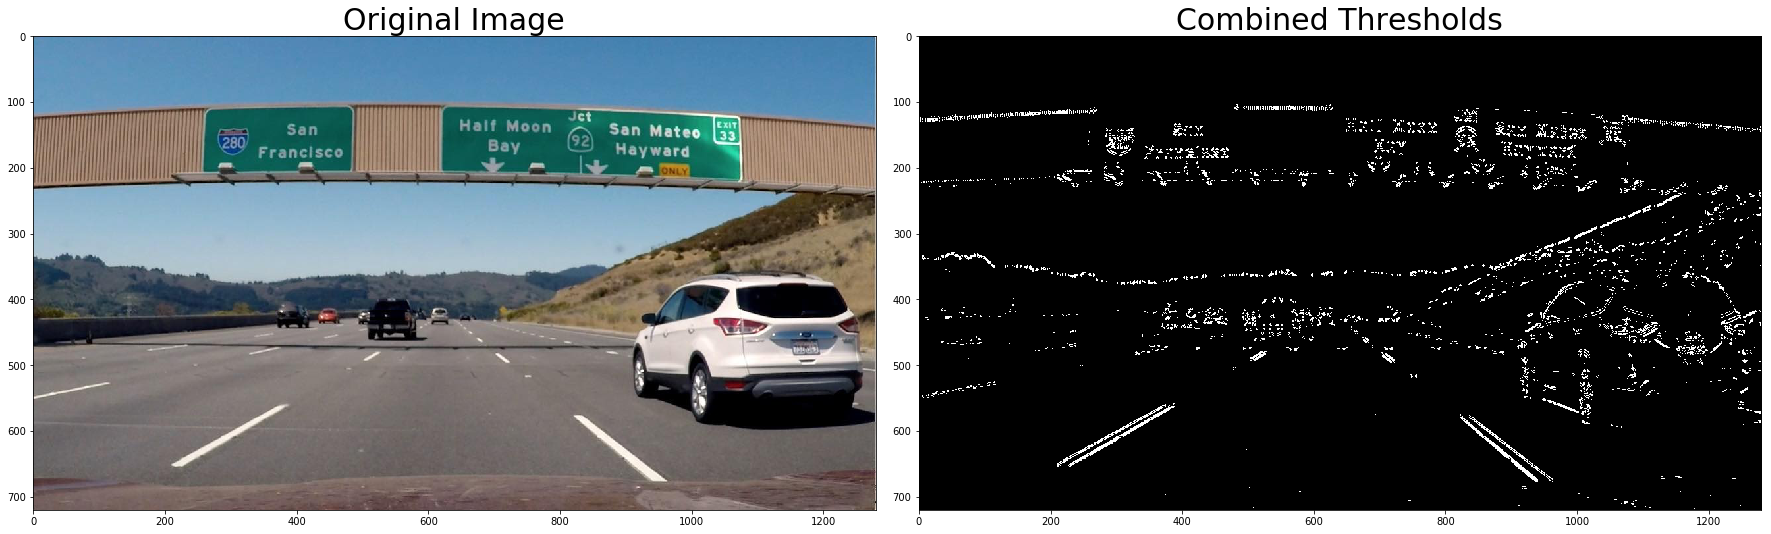

In [31]:
#tom's early testing

def testing_combined_thresholds(image):
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined
    
image = mpimg.imread('./examples/signs_vehicles_xygrad.png')
combined_threshold = testing_combined_thresholds(image)
plot2images(image1=image, image2=combined_threshold, title1='Original Image', title2='Combined Thresholds', image2cmap='gray', save_filename='output_images/combined_thresholds.png')

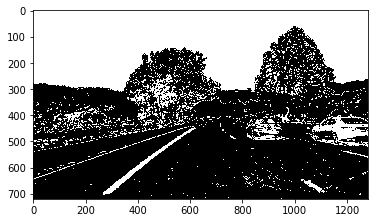

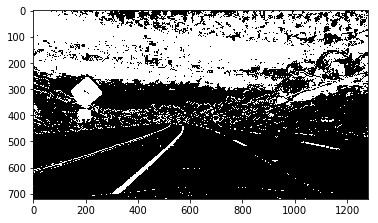

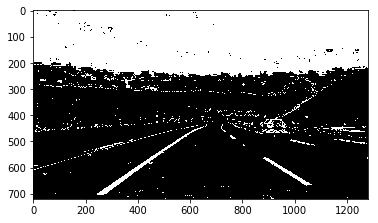

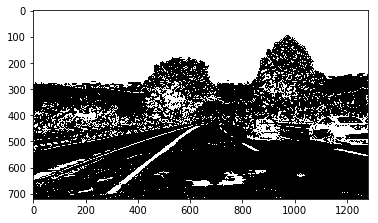

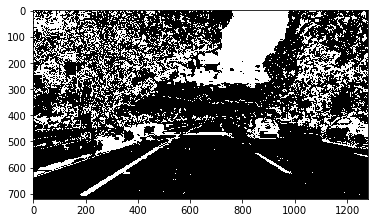

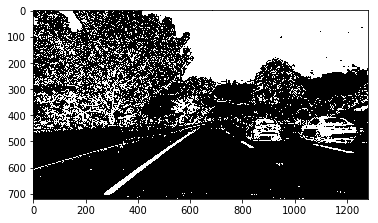

In [27]:
import numpy as np
import cv2
import pickle
import glob
#from tracker import tracker

# Read in the saved camera calibration settings
dist_pickle = pickle.load(open( "./calibration_pickle.p", "rb"))
mtx= dist_pickle['mtx']
dist = dist_pickle['dist']


def preprocess_image(image):
    ksize=5
    preprocessImage = np.zeros_like(image[:,:,0])
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    colorb = color_threshold(image, s_thresh=(100,255), v_thresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (colorb == 1))] = 1 
    #mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    #gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    #grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 100))
    #preprocessImage[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    #preprocessImage[((gradx == 1) & (grady == 1) | ((mag_binary == 1) & (dir_binary == 1) | (colorb == 1)))] = 1
    return preprocessImage

#use the test images
images = glob.glob('./test_images/test*.jpg')


for idx, fname in enumerate(images):
    # read in image
    img = cv2.imread(fname)
    
    # undistort the image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Preprocess Images
    preprocessedImage = preprocess_image(img)
    
    imageName = 'tracked'+str(idx)+'.jpg'
    plotImage(image=preprocessedImage, image_cmap='gray',  save_filename='./output_images/'+imageName)
    

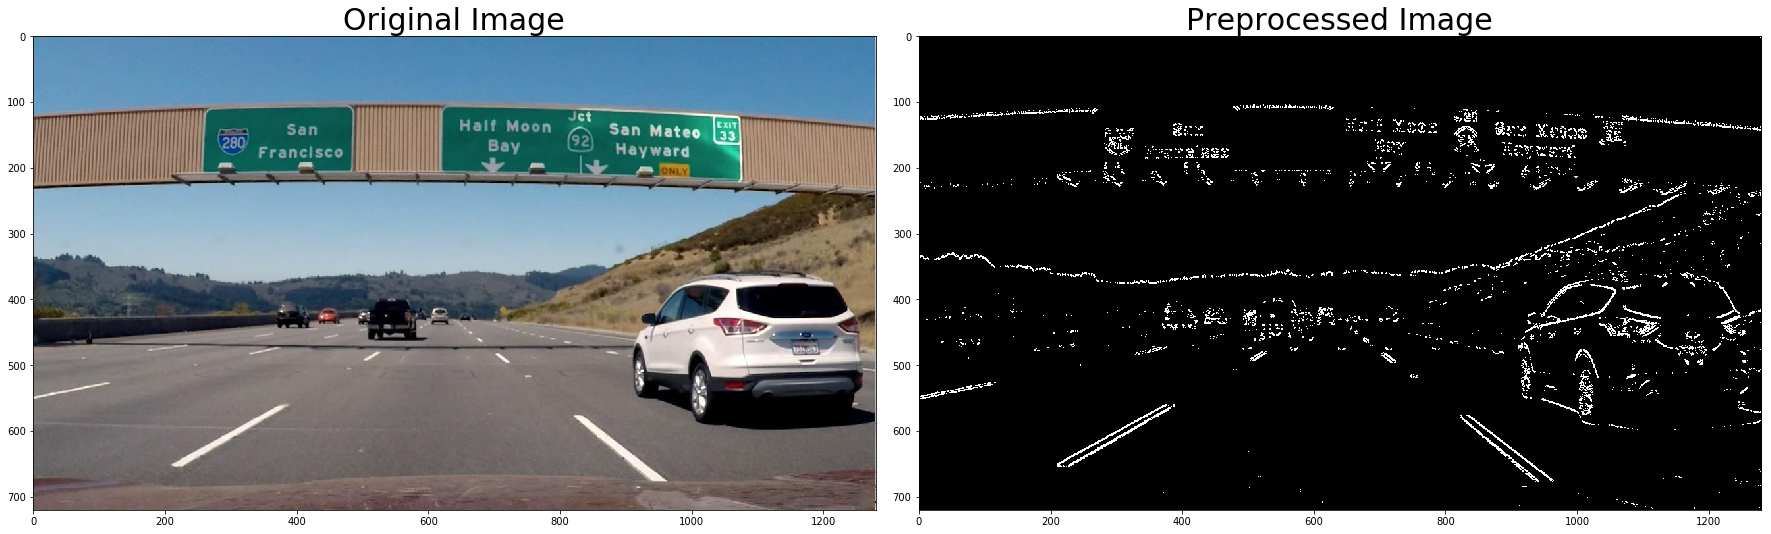

In [28]:
image = mpimg.imread('./examples/signs_vehicles_xygrad.png')
preprocessedImage = preprocess_image(image)
plot2images(image1=image, image2=preprocessedImage, title1='Original Image', title2='Preprocessed Image', image2cmap='gray', save_filename='output_images/orig_vs_preprocessed.png')

In [ ]:
image_size = (img.shape[1], img.shape[0])
bottom_width = .76        # percent of bottom trapizoid height
middle_width = .08        # percent of middle trapizoid height
height_percentage = .62   # percent of the trapezoid height
bottom_trim = .935        # percent from top to bottom to avoid car hood
src = np.float32([[img.shape[1]*(.5-middle_width/2), img.shape[0]*height_percentage],
                  [img.shape[1]*(.5+middle_width/2), img.shape[0]*height_percentage]])
offset = img_size[0]*.25
dst = np.float32([[offset, 0], 
                  [img_size[0]-offset, 0], 
                  [img_size[0]+offset, img_size[1]],
                  [offset, img_size[1]]])

In [ ]:
### Apply a perspective transform to rectify binary image ("birds-eye view").

### Color Thresholds

R channel still does rather well on the white lines, perhaps even better than the S channel. 
  As with gradients, it's worth considering how you might combine various color thresholds to 
  make the most robust identification of the lines.

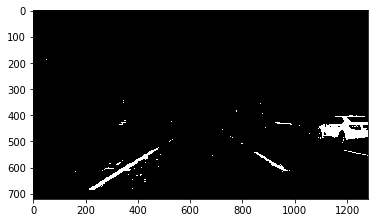

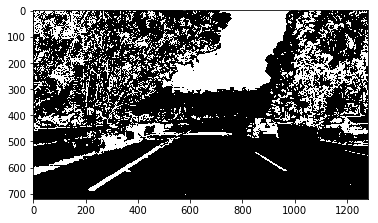

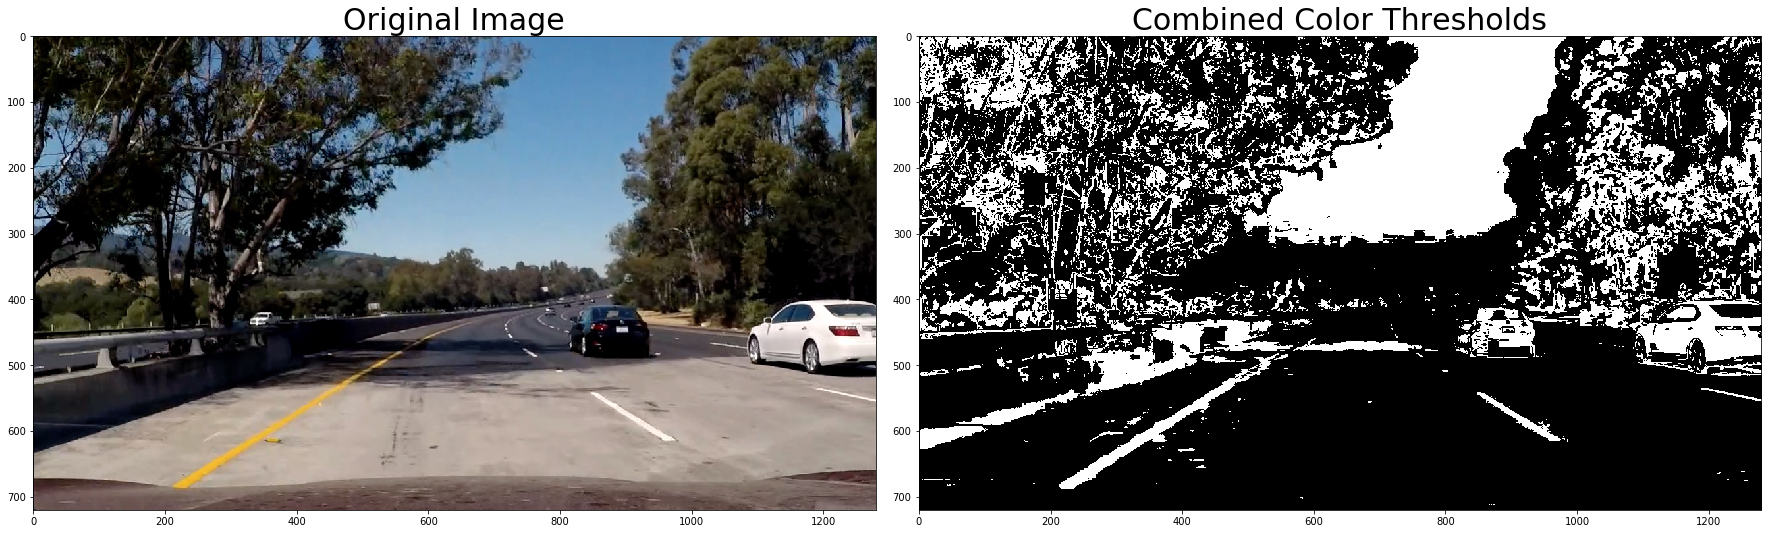

In [35]:
def G_thres(image, g_thresh=(0, 255)):
    # Calculate the R Channel Threshold
    G = image[:,:,1]
    g_binary = np.zeros_like(G)
    g_binary[(G > g_thresh[0]) & (G <= g_thresh[1])] = 1
    return g_binary

def R_thres(image, r_thresh=(0, 255)):
    # Calculate the R Channel Threshold
    R = image[:,:,0]
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    return r_binary

def S_thres(image, s_thresh=(0, 255)):
    # Calculate the S Channel Threshold
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    thresh = (90, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return s_binary

def testing_yellow_lanes(image):
    r_binary = R_thres(image, r_thresh = (200, 255))
    g_binary = G_thres(image, g_thresh = (20, 100))
    combined = np.zeros_like(r_binary)
    combined[((r_binary == 1) | (g_binary == 1))] = 1
    return combined

def testing_white_lanes(image):
    r_binary = R_thres(image, r_thresh = (200, 255))
    s_binary = S_thres(image, s_thresh = (20,100))
    combined = np.zeros_like(r_binary)
    combined[((r_binary == 1) & (s_binary == 1))] = 1
    return combined

def testing_combined_colors_thresholds(image):
    r_binary = R_thres(image, r_thresh = (200, 255))
    s_binary = S_thres(image, s_thresh = (0, 75))
    combined = np.zeros_like(r_binary)
    combined[((r_binary == 1) | (s_binary == 1))] = 1
    return combined

    
#image = mpimg.imread('./examples/signs_vehicles_xygrad.png')
#image = mpimg.imread('./examples/bridge_shadow.jpg')
#image = mpimg.imread('./test_images/test5.jpg')

r_binary = R_thres(image, r_thresh = (200, 255))
#g_binary = G_thres(image, g_thresh = (0, 50))
s_binary = S_thres(image, s_thresh = (0,75))

#plt.title = 'R Channel'
#plt.savefig('./output_images/chessboard.png')
#plt.imshow(r_binary, cmap='gray')
#plt.show()

r_binary = R_thres(image, r_thresh = (200, 255))
plt.imshow(r_binary, cmap='gray')
plt.show()

plt.imshow(s_binary, cmap='gray')
plt.show()

#plot2images(image1=r_binary, image2=g_binary, title1='R Channel', title2='G Channel', image1cmap='gray', image2cmap='gray', save_filename='output_images/r_s_thresholds.png')
#s_binary = S_thres(image, s_thresh = (90, 255))
#plot2images(image1=s_binary, image2=s_binary, title1='S Channel', title2='S Channel', image1cmap='gray', image2cmap='gray', save_filename='output_images/r_s_thresholds.png')

combined_threshold = testing_combined_colors_thresholds(image)
plot2images(image1=image, image2=combined_threshold, title1='Original Image', title2='Combined Color Thresholds', image2cmap='gray', save_filename='output_images/combined_color_thresholds.png')




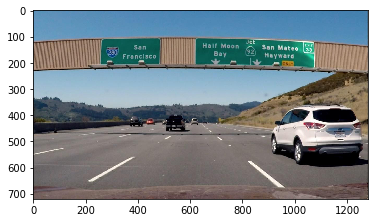

In [44]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Create a masked image
image = mpimg.imread('./examples/signs_vehicles_xygrad.png')

image_y = image.shape[0]
image_x = image.shape[1]
x_factor = 40
y_factor = 60
vertices = np.array([[
        (0,image_y),
        (((image_x/2)- x_factor), (image_y/2)+ y_factor), 
         (((image_x/2) + x_factor), (image_y/2)+ y_factor), 
         (image_x,image_y)]], dtype=np.int32)
masked_edges = region_of_interest(image, vertices)

masked_edges = region_of_interest(image, vertices)
plotImage(image=image,  save_filename=None)
          #'./output_images/'+imageName)
    



In [ ]:
def create_threshold_binary_image(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    #plot2images(l_channel, scaled_sobel, "Grayscale", "Scaled Sobel", image1cmap='gray', image2cmap='gray', save_filename='./output_images/grayscaleAndScaledSobel.png')
    
    #sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel2 = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #plot2images(scaled_sobel, scaled_sobel2, "Grayscale", "L Channel", image1cmap='gray', image2cmap='gray', save_filename='./output_images/GreyAndLScaledSobels.png')
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    #plot2images(sxbinary, s_binary, "Threshold x Gradient", "Threshold Color Channel", image1cmap='gray', image2cmap='gray', save_filename='./output_images/thresholds.png')
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    #plt.imshow(color_binary)
    #plt.savefig('output_images/color_binary.png')
    #plt.show()

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return (color_binary, combined_binary)

# Some interesting things to explore might include: the H channel, different 
# threshold values for color and gradient binary images, and even a different 
# color space, like HSV!

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

image = mpimg.imread('./examples/color-shadow-example.jpg')
##image = mpimg.imread('./examples/signs_vehicles_xygrad.png')
color_binary, tbinary_image = create_threshold_binary_image(image)
plot2images(image1=color_binary, image2=tbinary_image, title1='Stacked thresholds', title2='Combined S channel and gradient thresholds', image2cmap='gray', save_filename='output_images/orig_vs_combinedThresholds.png')

#plt.imshow(color_binary)
#plt.savefig('output_images/color_binary.png')
#plt.show()



In [ ]:
### Detect lane pixels and fit to find the lane boundary.

In [ ]:
### Determine the curvature of the lane and vehicle position with respect to center.


In [ ]:
### Warp the detected lane boundaries back onto the original image.


In [ ]:
### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Calibrating a Camera

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read in a calibration image
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

In [ ]:
import glob
%matplotlib qt

images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images
objpoints =[] #3D points in real world space
imgpoints =[] #2D points in image plane

# Prepare object points, like (0,0, 0), (1,0,0), (2,0,0), ...,  (7,5,0)
objp = np.zeros((6*8, 3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2) 
#objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2) #x, y coordinates

for fname in images:
    # Read om each image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    # mpimg.imread() this will read in an RGB image
    # cv2.imread () or glob API this will read in a BGR image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    
    
    

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
        plt. imshow(img)
        
        
# To calibrate a camera
# gray.shape[::-1] is equivalent to img.shape[0:2] <-- first two values of a color image shape
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)



### Perspective transform

In [ ]:
#Examples of Useful Code

#Compute the perspective transform, M, given source and destination points:
M = cv2.getPerspectiveTransform(src, dst)

#Compute the inverse perspective transform:
#
Minv = cv2.getPerspectiveTransform(dst, src)

#Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

In [ ]:
# defiine perspective transform function
def warp(img):
    # Define calibration box in source (original and destination(desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])

    # Four source coordinates
    src = np.float(32(
    [[850,320],
     [865, 450],
     [533, 350],
     [535, 210]]))

    # Four destination coordinates
    dest = np.float(32(
    [[870, 240],
     [870, 370],
     [520, 370],
     [520, 240]]))
                    
    #Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dest)

    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dest, src)

    #Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR) 
    
    retrun
                   

In [ ]:
%matplotlib inline

# get perspective transform
warped_img = warp(img)

# Visualize distortion
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.set_title('Source image')
ax1.imshow(img)
ax2.set_title('Warped image')
ax2.imshow(warped_image)

In [ ]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

In [ ]:
### Gradient Threshold
### Canny

In [ ]:
### Sobel Operator


In [ ]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary    

# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
### Magnitude of the Gradient

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image
image = mpimg.imread('signs_vehicles_xygrad.png')

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    #return binary_output
    return sxbinary
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
### Direction of the gradient

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import pickle
%matplotlib inline


# Read in an image
image = mpimg.imread('signs_vehicles_xygrad.png')

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
   
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
### Combining Thresholds

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import pickle
%matplotlib inline




# Read in an image
image = mpimg.imread('./examples/signs_vehicles_xygrad.png')

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
   
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return dir_binary




# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
#plt.imshow(gradx, cmap='gray')
#plt.show()

grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
#plt.imshow(gradx, cmap='gray')
#plt.show()

mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
#plt.imshow(gradx, cmap='gray')
#plt.show()

#dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
#plt.imshow(gradx, cmap='gray')
#plt.show()
#Try different combinations and see what you get.
# For example, here is a selection for pixels where both the x and y gradients meet the threshold criteria, 
#  or the gradient magnitude and direction are both within their threshold values.

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')
plt.show()

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [ ]:
### Colorspace Thresholding

In [ ]:
# RGB matplotlib.image.imread()
# BGR cv2.imread()
# HSV color space (hue, saturation, and value), and 
# HLS space (hue, lightness, and saturation)


# R channel still does rather well on the white lines, perhaps even better than the S channel. 
#  As with gradients, it's worth considering how you might combine various color thresholds to 
#  make the most robust identification of the lines.


# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread('test6.jpg') 

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2] 
    # 2) Apply a threshold to the S channel
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1

    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary
    
hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [ ]:
### Combining Color and Gradient

In [ ]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
#gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

# Some interesting things to explore might include: the H channel, different 
# threshold values for color and gradient binary images, and even a different 
# color space, like HSV!

In [ ]:
#### pipeline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



# Edit this function to create your own pipeline.
def pipeline(img, sobel_kernel=ksize, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hsv[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #plt.imshow(scaled_sobel)
    #plt.show()
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    #plt.imshow(sxbinary)

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    plt.show()
    return combined_binary
    
#image = mpimg.imread('./examples/bridge_shadow.jpg')
image = mpimg.imread('./examples/color-shadow-example.jpg')
#image = mpimg.imread('./examples/signs_vehicles_xygrad.png')

#result = pipeline(image, sobel_kernel=3, s_thresh=(170, 255), sx_thresh=(20, 100))
result = pipeline(image, sobel_kernel=7, s_thresh=(170,240), sx_thresh=(20, 140))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

In [ ]:
# Camera Calibration
# Distortion Correction


# Color & Gradient Threshold
# Perspective Transform
    
# find the lines
    #straight
    #curved

#Line Finding Method: Peaks in a Histogram
#Implement Sliding Windows and Fit a Polynomial